We are going to try different numerical methods learnt in class on the [Google PageRank problem](https://en.wikipedia.org/wiki/PageRank).

### (1)

Let $\mathbf{A} \in \{0,1\}^{n \times n}$ be the connectivity matrix of $n$ web pages with entries
$$
\begin{eqnarray*}
	a_{ij}= \begin{cases}
	1 & \text{if page $i$ links to page $j$} \\
	0 & \text{otherwise}
	\end{cases}.
\end{eqnarray*}
$$
$r_i = \sum_j a_{ij}$ is the out-degree of page $i$. That is $r_i$ is the number of links on page $i$. Imagine a random surfer exploring the space of $n$ pages according to the following rules.  

- From a page $i$ with $r_i>0$
    * with probability $p$, (s)he randomly chooses a link on page $i$ (uniformly) and follows that link to the next page  
    * with probability $1-p$, (s)he randomly chooses one page from the set of all $n$ pages (uniformly) and proceeds to that page  
- From a page $i$ with $r_i=0$ (a dangling page), (s)he randomly chooses one page from the set of all $n$ pages (uniformly) and proceeds to that page  
    
The process defines a Markov chain on the space of $n$ pages. Write down the transition matrix $\mathbf{P}$ of the Markov chain as a sparse matrix plus rank-1 matrix.

Solution:

$$P_{ij} = p\frac{a_{ij}}{r_i} + (1-p)\frac{1}{n}$$
when $r_i>0$
$$P = diag(\frac{p}{r_1}, ...,\frac{p}{r_n})A + \frac{(1-p)}{n}1_n1_n^T$$
when $r_i=0$
$$P=\frac{1}{n}$$
Because $A$ is a sparse matrix, so the above format is a sparse matrix plus a rank-1 matrix.

### (2)

According to standard Markov chain theory, the (random) position of the surfer converges to the stationary distribution $\mathbf{x} = (x_1,\ldots,x_n)^T$ of the Markov chain. $x_i$ has the natural interpretation of the proportion of times the surfer visits page $i$ in the long run. Therefore $\mathbf{x}$ serves as page ranks: a higher $x_i$ means page $i$ is more visited. It is well-known that $\mathbf{x}$ is the left eigenvector corresponding to the top eigenvalue 1 of the transition matrix $\mathbf{P}$. That is $\mathbf{P}^T \mathbf{x} = \mathbf{x}$. Therefore $\mathbf{x}$ can be solved as an eigen-problem. Show that it can also be cast as solving a linear system. Since the row sums of $\mathbf{P}$ are 1, $\mathbf{P}$ is rank deficient. We can replace the first equation by the $\sum_{i=1}^n x_i = 1$.

Solution:

$$x^TP=x^T$$
$$P^Tx=x$$ need to find the top eigen value of $P$
$$(P^T-I)x=0$$
so it can also be cast as solving a linear system

### (3)

Download the [`ucla.zip`](http://hua-zhou.github.io/teaching/biostatm280-2018spring/hw/hw3/ucla.zip) package from course webpage. Unzip the package, which contains two files `U.txt` and `A.txt`. `U.txt` lists the 500 URL names. `A.txt` is the $500 \times 500$ connectivity matrix. Read data into Julia. Compute summary statistics:
* number of pages
* number of edges
* number of dangling nodes (pages with no out links)
* which page has max in-degree?
* which page has max out-degree?
* visualize the sparsity pattern of $\mathbf{A}$

In [3]:
U = readdlm("U.txt", ',')
A = readdlm("A.txt", ',')

#pages
@show size(U)
@show size(A)

#edges (this need double check)
edges = sum(A,2)
@show sum(edges)

#dangling notes
nodes = countnz(edges)
dangling = 500 - nodes
@show dangling

# in-degree
in = sum(A,2)
@show indmax(in)

# out-degree
out = sum(A,1)
@show indmax(out)

size(U) = (500, 3)
size(A) = (500, 500)
sum(edges) = 11158.0
dangling = 96
indmax(in) = 36
indmax(out) = 1


1

1.the number of pages is 500

2.number of edges is 11158

3.number of dangling notes is 96

4.page 36 has the max in-degree 

5.page 1 has the max out-degree

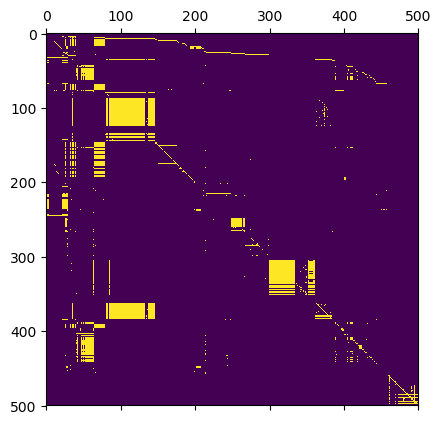

PyObject <matplotlib.image.AxesImage object at 0x119959f10>

In [8]:
# visulize sparsity pattern of A
using PyPlot
matshow(A)

### (4)

Set the _teleportation_ parameter at $p = 0.85$. Try the following methods to solve for $\mathbf{x}$ using the `ucla.zip` data.

0. A dense linear system solver such as LU decomposition.  
0. A simple iterative linear system solver such as Jacobi or Gauss-Seidel.   
0. A dense eigen-solver.  
0. A simple iterative eigen-solver such as the power method.  

For iterative methods, you can use the [`IterativeSolvers.jl`](https://github.com/JuliaMath/IterativeSolvers.jl) package. Make sure to utilize the special structure of $\mathbf{P}$ (diagonal + rank 1) to speed up the matrix-vector multiplication.

In [4]:
#1.
n = 500
p = 0.85

deg_in = sum(A,2)
intermediate = zeros(deg_in)
addin = zeros(A)

for i in collect(1:1:500) 
    if deg_in[i] > 0
        intermediate[i] = p/deg_in[i] 
        addin[i,:] = (1-p)/n
    elseif deg_in[i] == 0
        intermediate[i] = 0
        addin[i,:] = 1/n
    end 
end
                   
P = Diagonal(intermediate[:,]) * A + addin
P = sparse(P)

ones = [1 for i=1:500]
sub = transpose(P)-eye(n)
sub = vcat(ones',sub)

b = [0 for i=1:501]
b[1] = 1

sub\ b 

500-element Array{Float64,1}:
 0.0115263 
 0.00118521
 0.00368196
 0.00361842
 0.00118521
 0.00118521
 0.00118521
 0.00118521
 0.00118521
 0.00118521
 0.00118521
 0.00137118
 0.00133263
 ⋮         
 0.00136037
 0.00136037
 0.00129072
 0.00337188
 0.00215239
 0.00136037
 0.00136037
 0.00750605
 0.00136037
 0.00136037
 0.00136037
 0.00107129

2.
* Jacobi iteration: 
$$
x_i^{(t+1)} = \frac{b_i - \sum_{j=1}^{i-1} a_{ij} x_j^{(t)} - \sum_{j=i+1}^n a_{ij} x_j^{(t)}}{a_{ii}}.
$$

* With splitting: $\mathbf{A} = \mathbf{L} + \mathbf{D} + \mathbf{U}$, Jacobi iteration can be written as
$$
    \mathbf{D} \mathbf{x}^{(t+1)} = - (\mathbf{L} + \mathbf{U}) \mathbf{x}^{(t)} + \mathbf{b},
$$
i.e., 
$$
	\mathbf{x}^{(t+1)} = - \mathbf{D}^{-1} (\mathbf{L} + \mathbf{U}) \mathbf{x}^{(t)} + \mathbf{D}^{-1} \mathbf{b} = - \mathbf{D}^{-1} \mathbf{A} \mathbf{x}^{(t)} + \mathbf{x}^{(t)} + \mathbf{D}^{-1} \mathbf{b}.
$$



In [20]:
#2. interative linear solver
using IterativeSolvers

sub = transpose(P)-eye(n)
b = [0 for i=1:500]
b[1] = 1

xjacobi = jacobi(sub, b)
xjacobi/sum(xjacobi)

###not sure why the answer got for 
###this question is not the same as the other
###three questions

500-element Array{Float64,1}:
 0.103354  
 0.0038383 
 0.00611034
 0.00606293
 0.0038383 
 0.0038383 
 0.0038383 
 0.0038383 
 0.0038383 
 0.0038383 
 0.0038383 
 0.00413852
 0.00407511
 ⋮         
 0.00107226
 0.00104648
 0.00101735
 0.0023545 
 0.00152676
 0.00107226
 0.00107226
 0.00510904
 0.00107226
 0.00104661
 0.00107226
 0.00084458

In [15]:
#3. Eigen decomposition method

P = Diagonal(intermediate[:,]) * A + addin
tp = transpose(P)
eigen_vector = eigfact(tp)[:vectors][:,1]
eigen_vector/sum(eigen_vector)

500-element Array{Complex{Float64},1}:
  0.0115263+0.0im
 0.00118521+0.0im
 0.00368196+0.0im
 0.00361842+0.0im
 0.00118521+0.0im
 0.00118521+0.0im
 0.00118521+0.0im
 0.00118521+0.0im
 0.00118521+0.0im
 0.00118521+0.0im
 0.00118521+0.0im
 0.00137118+0.0im
 0.00133263+0.0im
           ⋮     
 0.00136037+0.0im
 0.00136037+0.0im
 0.00129072+0.0im
 0.00337188+0.0im
 0.00215239+0.0im
 0.00136037+0.0im
 0.00136037+0.0im
 0.00750605+0.0im
 0.00136037+0.0im
 0.00136037+0.0im
 0.00136037+0.0im
 0.00107129+0.0im

In [ ]:
4. A simple iterative eigen-solver such as the power method.

In [16]:
#4.
using IterativeSolvers
x = [1/500 for i in 1:500]
tp = transpose(P)

a,b = powm(tp,tol = 1e-5, maxiter = 500)
b/sum(b)   

500-element Array{Complex{Float64},1}:
  0.0115264+6.07769e-9im 
 0.00118522+5.14613e-10im
 0.00368198+1.7668e-9im  
 0.00361844+1.72739e-9im 
 0.00118522+5.14613e-10im
 0.00118522+5.14613e-10im
 0.00118522+5.14613e-10im
 0.00118522+5.14613e-10im
 0.00118522+5.14613e-10im
 0.00118522+5.14613e-10im
 0.00118522+5.14613e-10im
 0.00137119+6.06196e-10im
 0.00133264+5.79833e-10im
           ⋮             
 0.00136038+5.91986e-10im
 0.00136038+5.91986e-10im
 0.00129072+5.54565e-10im
  0.0033719+1.73886e-9im 
  0.0021524+1.10157e-9im 
 0.00136038+5.91986e-10im
 0.00136038+5.91986e-10im
  0.0075061+3.95281e-9im 
 0.00136038+5.91986e-10im
 0.00136038+5.91986e-10im
 0.00136038+5.91986e-10im
  0.0010713+4.42643e-10im

### (5)

List the top 20 ranked URLs you found.

In [17]:
ones = [1 for i=1:500]
sub = transpose(P)-eye(n)
sub = vcat(ones',sub)

b = [0 for i=1:501]
b[1] = 1

score = sub\ b 
ind = sortperm(score)
U[ind.<21,:]

20×3 Array{Any,2}:
 "http://www.ucla.edu/audience/future.html"            ""  ""
 "http://www.ucla.edu/audience/students.html"          ""  ""
 "http://www.ucla.edu/audience/parents.html"           ""  ""
 "http://www.ucla.edu/audience/faculty.html"           ""  ""
 "http://www.ucla.edu/audience/staff.html"             ""  ""
 "http://www.ucla.edu/audience/kids-families.html"     ""  ""
 "http://www.ucla.edu/audience/alumni.html"            ""  ""
 "http://www.ucla.edu/audience/visitors.html"          ""  ""
 "http://www.ucla.edu/campusvalues"                    ""  ""
 "http://www.ucla.edu/healthsci.html"                  ""  ""
 "http://www.ucla.edu/terms.html"                      ""  ""
 "http://www.ucla.edu/contact.html"                    ""  ""
 "http://www.ucla.edu/connect.html"                    ""  ""
 "http://www.registrar.ucla.edu/facultystaff/ris.htm"  ""  ""
 "http://www.registrar.ucla.edu/cims"                  ""  ""
 "http://law.ucla.edu/academics/academic-calendar" 

### (6)

As of Monday May 11 2018, there are at least 1.83 billion indexed webpages on internet according to <http://www.worldwidewebsize.com/>. Explain whether each of these methods works for the PageRank problem at this scale.

a. The dense linear system solver such as LU decomposition will become problematic when the data is huge. The decomposition takes much memory to store the big matrix.

b. The simple iterative linear system solver such as Jacobi or Gauss-Seidel works better, but probably be slow and memory taking to store the matrix.

c. The dense eigen-solver will waste time and memory on calculating all eigen vectors while we just care about the first one.

d. The simple iterative eigen-solver such as the power method seems like a promising way to solve the problem. But many optimizations still required.